In [2]:
from dask.distributed import Client, progress

In [1]:
client = Client(threads_per_worker=4, n_workers=2)
client

/opt/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37389 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:35961 Dashboard: http://127.0.0.1:37389/status,Cluster Workers: 2 Cores: 8 Memory: 540.15 GB


In [2]:
client.cluster.scale(4)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:37827 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 0.98 TiB


___

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from scipy import interpolate
import pickle
import dask

In [189]:
def Generate():
        time.sleep(0.1)
        # np.random.seed(123)
        return np.random.randint(1,10,5)
        
    

In [5]:
%%time
for ii in range(5):
    
    results = []
    
    for jj in range(10):
        
        aa = Generate()        
        results.append(aa)
    
    bb = np.vstack((results))
    # print(bb)

CPU times: user 3.71 ms, sys: 2.38 ms, total: 6.09 ms
Wall time: 5.01 s


In [192]:
client = Client(threads_per_worker=5, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:42105 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 50 Memory: 540.15 GB


In [194]:
%%time

bbs = []

for ii in range(5):
    
    results = []
    
    for jj in range(10):
        
        aa = dask.delayed(Generate)()        
        results.append(aa)
    
    # bb = dask.delayed(np.vstack)((results))
    
    bbs.append(dask.delayed(np.vstack)((results)))
    
sum(bbs).compute()

# aa = dask.compute(sum(bbs))[0]

CPU times: user 38.6 ms, sys: 13.8 ms, total: 52.5 ms
Wall time: 170 ms


array([[15, 22, 24, 29, 29],
       [25, 26, 27, 26, 31],
       [31, 24, 18, 15, 34],
       [27, 29, 17, 31, 21],
       [27, 28, 38, 28, 18],
       [28, 31, 33, 22, 20],
       [29, 24, 33, 20, 20],
       [16, 28, 33, 31, 20],
       [18, 16, 26, 23, 21],
       [29, 29, 35, 27, 24]])

In [164]:
# np.random.seed(132)
bb = dask.delayed(np.random.random)((5,5))

In [191]:
client.close()

In [162]:
aa = np.random.randint(1,10,5)
bb = [aa, aa, aa]

In [127]:
cc = np.vstack(bb)

In [136]:
List = list(np.random.rand(5))

In [137]:
List

[0.9431532953754311,
 0.07525658440692351,
 0.27687252952929386,
 0.9795706809438219,
 0.10663601701872794]

In [169]:
aa = np.random.rand(5,5)
aa

array([[0.72828295, 0.17747756, 0.96045143, 0.12665212, 0.8773446 ],
       [0.27987421, 0.87531544, 0.7507514 , 0.13233317, 0.12509612],
       [0.87023371, 0.79689174, 0.86154617, 0.42230363, 0.10651125],
       [0.20023368, 0.23911258, 0.10258091, 0.96279501, 0.01412832],
       [0.60974902, 0.27735673, 0.80800113, 0.03465429, 0.94051416]])

In [187]:
time.ctime()

'Mon Dec 27 03:53:31 2021'

In [182]:
tt = time.gmtime()
tt

time.struct_time(tm_year=2021, tm_mon=12, tm_mday=27, tm_hour=3, tm_min=30, tm_sec=50, tm_wday=0, tm_yday=361, tm_isdst=0)

In [184]:
tt.tm_mday

27

In [186]:
time.strftime('%m%d_%H%M')

'1227_0353'

In [3]:
def inc(x):
    return x + 1

def add(x, y):
    return x + y

In [4]:
a = client.submit(inc, 10)  # calls inc(10) in background thread or process
b = client.submit(inc, 20)  # calls inc(20) in background thread or process

In [5]:
type(b)

distributed.client.Future

In [6]:
c = client.map(inc, range(10))

In [7]:
type(c)

list

In [8]:
client.gather(b)

21

In [53]:
aa = client.map(add, [1,2,3], y=2)

In [54]:
client.gather(aa)

[3, 4, 5]

In [87]:
bb=[]
for ii in [1,2,3]:
    bb.append(dask.delayed(add)(ii, 2))   

In [88]:
dask.compute(*bb)

(3, 4, 5)

In [61]:
len(bb)

3

In [10]:
def inc(x):
    return x + 1

def add(x, y):
    return x + y

def function(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

In [20]:
client.submit(function, 1, 3)
    

<Future: pending, key: function-a5cea08e91a6fa844098caa98f390f72>

In [5]:
L = client.map(inc, range(10), range(10, 20))

NameError: name 'inc' is not defined

In [62]:
xx = np.arange(0,5,0.1)
yy = np.arange(0,10,0.1)

In [63]:
MM = np.meshgrid(xx, yy)

In [64]:
MM[0]

array([[0. , 0.1, 0.2, ..., 4.7, 4.8, 4.9],
       [0. , 0.1, 0.2, ..., 4.7, 4.8, 4.9],
       [0. , 0.1, 0.2, ..., 4.7, 4.8, 4.9],
       ...,
       [0. , 0.1, 0.2, ..., 4.7, 4.8, 4.9],
       [0. , 0.1, 0.2, ..., 4.7, 4.8, 4.9],
       [0. , 0.1, 0.2, ..., 4.7, 4.8, 4.9]])

In [65]:
MM[1]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       ...,
       [9.7, 9.7, 9.7, ..., 9.7, 9.7, 9.7],
       [9.8, 9.8, 9.8, ..., 9.8, 9.8, 9.8],
       [9.9, 9.9, 9.9, ..., 9.9, 9.9, 9.9]])

In [66]:
MM[0].flatten()

array([0. , 0.1, 0.2, ..., 4.7, 4.8, 4.9])

In [67]:
MM[1].flatten()

array([0. , 0. , 0. , ..., 9.9, 9.9, 9.9])

In [68]:
future = client.map(function, MM[0].flatten(), MM[1].flatten())

In [69]:
RR = client.gather(future)

In [70]:
RR = np.array(RR).reshape(MM[0].shape)

In [71]:
RR

array([[0.0000e+00, 1.0000e-02, 4.0000e-02, ..., 2.2090e+01, 2.3040e+01,
        2.4010e+01],
       [1.0000e-02, 2.0000e-02, 5.0000e-02, ..., 2.2100e+01, 2.3050e+01,
        2.4020e+01],
       [4.0000e-02, 5.0000e-02, 8.0000e-02, ..., 2.2130e+01, 2.3080e+01,
        2.4050e+01],
       ...,
       [9.4090e+01, 9.4100e+01, 9.4130e+01, ..., 1.1618e+02, 1.1713e+02,
        1.1810e+02],
       [9.6040e+01, 9.6050e+01, 9.6080e+01, ..., 1.1813e+02, 1.1908e+02,
        1.2005e+02],
       [9.8010e+01, 9.8020e+01, 9.8050e+01, ..., 1.2010e+02, 1.2105e+02,
        1.2202e+02]])

In [72]:
RR.shape

(100, 50)

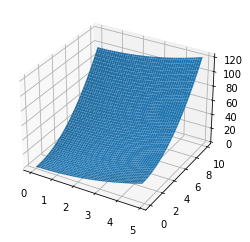

In [73]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(MM[0],MM[1], RR)


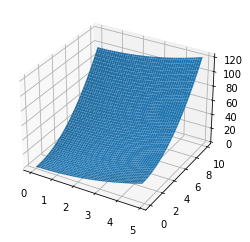

In [75]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(MM[0],MM[1], MM[0]**2+MM[1]**2)


In [57]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator


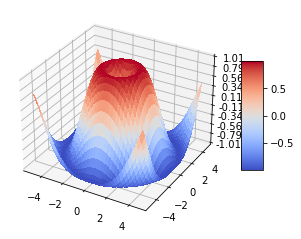

In [58]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [60]:
X.shape

(40, 40)

In [16]:
import time
import random

def costly_simulation(list_param):
    time.sleep(random.random())
    return sum(list_param)

In [17]:
import dask
lazy_results = []

In [19]:
import pandas as pd
import numpy as np

input_params = pd.DataFrame(np.random.random(size=(500, 4)),
                            columns=['param_a', 'param_b', 'param_c', 'param_d'])
input_params.head()

,param_a,param_b,param_c,param_d
0,0.727540,0.533437,0.489232,0.948024
1,0.958734,0.585661,0.085179,0.621185
2,0.615474,0.637609,0.425324,0.208987
3,0.057558,0.692922,0.048415,0.966129
4,0.070456,0.440332,0.946259,0.823255


In [20]:
%%time

for parameters in input_params.values[:10]:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

CPU times: user 3.16 ms, sys: 29 µs, total: 3.18 ms
Wall time: 2.16 ms


In [22]:
lazy_results[0]

Delayed('costly_simulation-72b8aba5-f078-4a24-bee9-9c3b3efc45ae')

In [21]:
%time dask.compute(*lazy_results)

ImportError: cannot import name 'dumps_msgpack' from 'distributed.protocol.core' (/usr/common/software/python/3.8-anaconda-2021.05/lib/python3.8/site-packages/distributed/protocol/core.py)

In [11]:
#Read in raw data Interp_load and TimeRange_load.
#Interp_load is a dictionary with 6 keys (bands in our case), 
#the item of each of them is a list that contains 40000 functions interpolated with scipy interp1d.
#TimeRange_load tells their domains of definition.

FilePath = '/global/homes/l/lianming/Presto-Color-2/data/2Day_Interp/SNIa-SALT2_Interp.pkl'

with open(FilePath, 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)  

In [12]:
Interp_load['u'][0]

In [13]:
Interp_load = {key: Interp_load[key][0:10] for key in Interp_load.keys()}
TimeRange_load = {key: TimeRange_load[key][0:10] for key in TimeRange_load.keys()}

In [9]:
def CalculateMap(dT1, dT2=300, 
                 Interp_load=Interp_load, TimeRange_load=TimeRange_load, 
                 Band1='g', Band2='i',  
                 PointsPDay = 1, Thr=27.5, ObjNo=10):
        
    dMag = []
    Color = []
    
    if ObjNo == None:
        ObjNo = len(Interp_load[Band1])

    for II in range(ObjNo):
        
        if Interp_load[Band1][II]==[] or Interp_load[Band2][II]==[]:
            continue
            
        TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
        TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )

        TimeRange = TimeRangeEnd - TimeRangeStart
        SampleNo = np.int(PointsPDay*TimeRange)
        
        XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart

        Mag1 = Interp_load[Band1][II](XX)
        Mag2 = Interp_load[Band2][II](XX+dT1/1440)
        Mag12 = Interp_load[Band1][II](XX+dT2/1440)

        Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)

        dMag.extend(Mag1[Mask] - Mag12[Mask])
        Color.extend(Mag1[Mask] - Mag2[Mask])
        
    data = np.array([dMag, Color])
    
    return data

NameError: name 'Interp_load' is not defined

In [15]:
def reduce(results):
    
    dMags = []
    Colors = []
    
    for dMag, Color in results:
        
#         print(len(dMag), len(Color))
        dMags.extend(dMag)
        Colors.extend(Color)
    print(len(dMags), len(Colors))
    return np.array([dMags, Colors])

In [16]:
dT1s = np.arange(0,60, 15)

In [17]:
dT1s

array([ 0, 15, 30, 45])

---
When run directly.

In [22]:
%%time
map = CalculateMap(dT1=30, dT2=300, Interp_load=Interp_load, TimeRange_load=TimeRange_load, Band1='g', Band2='i', PointsPDay=0.1)

CPU times: user 7.24 ms, sys: 0 ns, total: 7.24 ms
Wall time: 5.63 ms


---
Try with delayed and compute

In [36]:
Path1 = '/global/cscratch1/'
Path2 = '/global/homes/l/lianming/Presto-Color-2/data/2Day_Interp'

########################################################
#Parameter setting

PathInterp = Path1

# EventNames = np.load(os.path.join(PathInterp, 'EventName.npy'))
# EventNames = ['AGN', 'CART', 'EB', 'ILOT', 'KN_B19', 'KN_K17', 'MIRA', 'Mdwarf',
#               'PISN', 'RRL', 'SLSN-I', 'SNII-NMF', 'SNII-Templates', 'SNIIn',
#               'SNIa-91bg', 'SNIa-SALT2', 'SNIax', 'SNIbc-MOSFIT',
#               'SNIbc-Templates', 'TDE', 'V19_CC+HostXT', 'uLens-Binary',
#               'uLens-Single-GenLens', 'uLens-Single_PyLIMA']

# EventNames = [EventNames[23]]
EventNames = [ 'SNIa-SALT2', 'AGN']

PointsPerDay = 1
Objects = np.arange(0, 40000, 4)

# Bands = ['u', 'g', 'r', 'i', 'z', 'Y']
Bands = ['g', 'r', 'i']

# PointsPerDay = 1
# ObjNo = 10000

Thrs = {'u': 23.9, 'g': 25.0, 'r': 24.7, 'i': 24.0, 'z': 23.3, 'Y': 22.1}

#########################################################
#Generating file paths, filter pairs

Paths = [os.path.join(PathInterp, ii+'_Interp.pkl') for ii in EventNames]
BandPairs = [B1+B2 for B1 in Bands for B2 in Bands if B1!=B2 and B1+B2!='uz' and B1+B2!='zu']

FilePath_BandPair = [ [ii, jj] for ii in Paths for jj in BandPairs]


In [41]:
def GeneratePath(EventName, PathInterp=PathInterp):
    return os.path.join(PathInterp, EventName+'_Interp.pkl')

def Path_BandPare(BandPairs, Path):
    return [Path, BandPairs]


In [18]:
GeneratePath('AGN')

'/global/cscratch1/sd/lianming/data/2Day_Interp/AGN_Interp.pkl'

In [19]:
Pathfuture = client.map(GeneratePath, EventNames)

In [21]:
client.gather(Pathfuture)

['/global/cscratch1/sd/lianming/data/2Day_Interp/SNIa-SALT2_Interp.pkl',
 '/global/cscratch1/sd/lianming/data/2Day_Interp/AGN_Interp.pkl']

In [22]:
BandPairs

['gr', 'gi', 'rg', 'ri', 'ig', 'ir']

In [23]:
client.map(Path_BandPare, EventNames, BandPairs)

[<Future: pending, key: Path_BandPare-e102c6a62a468f89f2b03ae0a83ef033>,
 <Future: pending, key: Path_BandPare-04fd069c08b0a82e43dfa55f9fba9840>]

In [32]:
client.gather(client.map(Path_BandPare, BandPairs, Path=['agn']))

[[['agn'], 'gr'],
 [['agn'], 'gi'],
 [['agn'], 'rg'],
 [['agn'], 'ri'],
 [['agn'], 'ig'],
 [['agn'], 'ir']]

In [25]:
BandPairs

['gr', 'gi', 'rg', 'ri', 'ig', 'ir']

In [42]:
lazy_results = []

for Event in EventNames:
    
    PathDelayed = dask.delayed(GeneratePath)(Event)
    
    lazy_results.append(client.map(Path_BandPare, BandPairs, Path=PathDelayed))

In [78]:
dask.compute(*client.gather(lazy_results))

(['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gr'],
 ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gi'],
 ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'rg'],
 ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ri'],
 ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ig'],
 ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ir'],
 ['/global/cscratch1/AGN_Interp.pkl', 'gr'],
 ['/global/cscratch1/AGN_Interp.pkl', 'gi'],
 ['/global/cscratch1/AGN_Interp.pkl', 'rg'],
 ['/global/cscratch1/AGN_Interp.pkl', 'ri'],
 ['/global/cscratch1/AGN_Interp.pkl', 'ig'],
 ['/global/cscratch1/AGN_Interp.pkl', 'ir'])

In [79]:
lazy_results_T = []

for Event in EventNames:
    
    lazy_results = []
    
    PathDelayed = dask.delayed(GeneratePath)(Event)
    
    for BandPair in BandPairs:
        lazy_results.append(dask.delayed(Path_BandPare)(BandPair, PathDelayed))
        
    lazy_results_T.append(lazy_results)
    

In [89]:
dask.compute(*lazy_results_T)

([['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gr'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gi'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'rg'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ri'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ig'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ir']],
 [['/global/cscratch1/AGN_Interp.pkl', 'gr'],
  ['/global/cscratch1/AGN_Interp.pkl', 'gi'],
  ['/global/cscratch1/AGN_Interp.pkl', 'rg'],
  ['/global/cscratch1/AGN_Interp.pkl', 'ri'],
  ['/global/cscratch1/AGN_Interp.pkl', 'ig'],
  ['/global/cscratch1/AGN_Interp.pkl', 'ir']])

In [90]:
dask.compute(lazy_results_T)

([[['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gr'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gi'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'rg'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ri'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ig'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ir']],
  [['/global/cscratch1/AGN_Interp.pkl', 'gr'],
   ['/global/cscratch1/AGN_Interp.pkl', 'gi'],
   ['/global/cscratch1/AGN_Interp.pkl', 'rg'],
   ['/global/cscratch1/AGN_Interp.pkl', 'ri'],
   ['/global/cscratch1/AGN_Interp.pkl', 'ig'],
   ['/global/cscratch1/AGN_Interp.pkl', 'ir']]],)

In [91]:
cc = dask.persist(*lazy_results_T)

In [93]:
cc

([Delayed('Path_BandPare-c436e0ab-683e-4f21-81e4-95a5326d66be'),
  Delayed('Path_BandPare-014597d4-d5d6-4f39-be73-43c98bfe780d'),
  Delayed('Path_BandPare-bc9f1697-be63-4e48-9b5b-aa85b39acb70'),
  Delayed('Path_BandPare-104ea32e-ff6d-4d9b-99e9-6e4a95a3c723'),
  Delayed('Path_BandPare-a0bad528-780f-4e56-9c5e-87c8f247cf69'),
  Delayed('Path_BandPare-16eca81c-4956-4b19-84c5-1bc5e4a6565f')],
 [Delayed('Path_BandPare-e4e34e5d-742d-4a7f-8864-43f47bc59a57'),
  Delayed('Path_BandPare-36ca3f9b-c98e-4008-ad35-5ae3a6fe6f95'),
  Delayed('Path_BandPare-461c9c76-40ba-4a42-937c-dcafb657ec9a'),
  Delayed('Path_BandPare-61b1192a-bda2-4881-96e0-8f233b7eddf4'),
  Delayed('Path_BandPare-80065d6a-a90e-4117-accd-b3f0082bc279'),
  Delayed('Path_BandPare-a576cf6a-dc7f-45fa-b07b-6ab3970d5a5a')])

In [94]:
dask.persist(*lazy_results_T)

([Delayed('Path_BandPare-c436e0ab-683e-4f21-81e4-95a5326d66be'),
  Delayed('Path_BandPare-014597d4-d5d6-4f39-be73-43c98bfe780d'),
  Delayed('Path_BandPare-bc9f1697-be63-4e48-9b5b-aa85b39acb70'),
  Delayed('Path_BandPare-104ea32e-ff6d-4d9b-99e9-6e4a95a3c723'),
  Delayed('Path_BandPare-a0bad528-780f-4e56-9c5e-87c8f247cf69'),
  Delayed('Path_BandPare-16eca81c-4956-4b19-84c5-1bc5e4a6565f')],
 [Delayed('Path_BandPare-e4e34e5d-742d-4a7f-8864-43f47bc59a57'),
  Delayed('Path_BandPare-36ca3f9b-c98e-4008-ad35-5ae3a6fe6f95'),
  Delayed('Path_BandPare-461c9c76-40ba-4a42-937c-dcafb657ec9a'),
  Delayed('Path_BandPare-61b1192a-bda2-4881-96e0-8f233b7eddf4'),
  Delayed('Path_BandPare-80065d6a-a90e-4117-accd-b3f0082bc279'),
  Delayed('Path_BandPare-a576cf6a-dc7f-45fa-b07b-6ab3970d5a5a')])

In [96]:
dask.compute(dask.persist(*lazy_results_T))

(([['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gr'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gi'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'rg'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ri'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ig'],
   ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ir']],
  [['/global/cscratch1/AGN_Interp.pkl', 'gr'],
   ['/global/cscratch1/AGN_Interp.pkl', 'gi'],
   ['/global/cscratch1/AGN_Interp.pkl', 'rg'],
   ['/global/cscratch1/AGN_Interp.pkl', 'ri'],
   ['/global/cscratch1/AGN_Interp.pkl', 'ig'],
   ['/global/cscratch1/AGN_Interp.pkl', 'ir']]),)

In [103]:
dask.compute(*lazy_results_T)

([['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gr'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gi'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'rg'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ri'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ig'],
  ['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'ir']],
 [['/global/cscratch1/AGN_Interp.pkl', 'gr'],
  ['/global/cscratch1/AGN_Interp.pkl', 'gi'],
  ['/global/cscratch1/AGN_Interp.pkl', 'rg'],
  ['/global/cscratch1/AGN_Interp.pkl', 'ri'],
  ['/global/cscratch1/AGN_Interp.pkl', 'ig'],
  ['/global/cscratch1/AGN_Interp.pkl', 'ir']])

In [116]:
lazy_results_T[0][0].compute()

['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gr']

In [113]:
Client.compute(lazy_results_T[1])

TypeError: compute() missing 1 required positional argument: 'collections'

In [112]:
dask.compute?

Signature: dask.compute(*args, **kwargs)
Docstring:
Compute several dask collections at once.

Parameters
----------
args : object
    Any number of objects. If it is a dask object, it's computed and the
    result is returned. By default, python builtin collections are also
    traversed to look for dask objects (for more information see the
    ``traverse`` keyword). Non-dask arguments are passed through unchanged.
traverse : bool, optional
    By default dask traverses builtin python collections looking for dask
    objects passed to ``compute``. For large collections this can be
    expensive. If none of the arguments contain any dask objects, set
    ``traverse=False`` to avoid doing this traversal.
scheduler : string, optional
    Which scheduler to use like "threads", "synchronous" or "processes".
    If not provided, the default is to check the global settings first,
    and then fall back to the collection defaults.
optimize_graph : bool, optional
    If True [default], the op

In [110]:
client.compute?

Signature:
client.compute(
    collections,
    sync=False,
    optimize_graph=True,
    workers=None,
    allow_other_workers=False,
    resources=None,
    retries=0,
    priority=0,
    fifo_timeout='60s',
    actors=None,
    traverse=True,
    **kwargs,
)
Docstring:
Compute dask collections on cluster

Parameters
----------
collections : iterable of dask objects or single dask object
    Collections like dask.array or dataframe or dask.value objects
sync : bool (optional)
    Returns Futures if False (default) or concrete values if True
optimize_graph : bool
    Whether or not to optimize the underlying graphs
workers : string or iterable of strings
    A set of worker hostnames on which computations may be performed.
    Leave empty to default to all workers (common case)
allow_other_workers : bool (defaults to False)
    Used with `workers`. Indicates whether or not the computations
    may be performed on workers that are not in the `workers` set(s).
retries : int (default to 0

In [111]:
Client.compute?

Signature:
Client.compute(
    self,
    collections,
    sync=False,
    optimize_graph=True,
    workers=None,
    allow_other_workers=False,
    resources=None,
    retries=0,
    priority=0,
    fifo_timeout='60s',
    actors=None,
    traverse=True,
    **kwargs,
)
Docstring:
Compute dask collections on cluster

Parameters
----------
collections : iterable of dask objects or single dask object
    Collections like dask.array or dataframe or dask.value objects
sync : bool (optional)
    Returns Futures if False (default) or concrete values if True
optimize_graph : bool
    Whether or not to optimize the underlying graphs
workers : string or iterable of strings
    A set of worker hostnames on which computations may be performed.
    Leave empty to default to all workers (common case)
allow_other_workers : bool (defaults to False)
    Used with `workers`. Indicates whether or not the computations
    may be performed on workers that are not in the `workers` set(s).
retries : int (de

In [48]:
Pathsfuture = client.map(GeneratePath, EventNames)
PathBandFuture = client.map(Path_BandPare, BandPairs, Pathsfuture)

In [49]:
client.gather(PathBandFuture)

[['/global/cscratch1/SNIa-SALT2_Interp.pkl', 'gr'],
 ['/global/cscratch1/AGN_Interp.pkl', 'gi']]

In [84]:
aa = np.arange(0, 40000, 8)

In [85]:
max(aa)

39992

In [86]:
aa.max()

39992

# From https://tutorial.dask.org/01_dask.delayed.html

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

In [3]:
from dask import delayed


In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [4]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [5]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)

total = sum(results)
print(total)

90
CPU times: user 309 ms, sys: 29.8 ms, total: 339 ms
Wall time: 10 s


In [6]:
%%time
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)

CPU times: user 1.64 ms, sys: 3.33 ms, total: 4.96 ms
Wall time: 3.78 ms


In [8]:
%time total.compute()

CPU times: user 128 ms, sys: 14.4 ms, total: 143 ms
Wall time: 1.12 s


90